# 뉴스 기사 크롤링 및 분류

1. Mecab - 형태소 분석기
 ``` python
$ git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
$ cd Mecab-ko-for-Google-Colab
$ bash install_mecab-ko_on_colab190912.sh
 ```

2. 파이썬 크롤링 및 자연어 처리 패키지
 ``` python
$ pip install beautifulsoup4
$ pip install newspaper3k
$ pip install konlpy
 ```

In [5]:
# 크롤링 도구
import requests
import pandas as pd
from bs4 import BeautifulSoup

## 하나의 카테고리의 데이터 수집 및 label

In [6]:
# BeautifulSoup 도구를 이용하여 URL 리스트를 리턴하는 함수
# 예시 페이지 : https://news.naver.com/main/list.nhn?mode=LSD&mid=sec&sid1=101&date=20200804&page=3 
# 원하는 페이지 수만큼 해당 카테고리 번호와 날짜를 가진 기사들의 url을 수집

def make_urllist(page_num, code, date):
    urllist=[]
    for i in range(1, page_num + 1):
        url = 'https://news.naver.com/main/list.nhn?mode=LSD&mid=sec&sid1='+str(code)+'&date='+str(date)+'&page='+str(i)
        news = requests.get(url)
        soup = BeautifulSoup(news.content, 'html.parser') # HTML 문법으로 작성되어져 있으니 HTML 문법을 기반으로 파싱하라는 의미
        news_list = soup.select('.newsflash_body .type06_headline li dl') # 하나의 기사 단위로 긁어오기
        news_list.extend(soup.select('.newsflash_body .type06 li dl')) # 한 페이지에 크게 두 블록으로 되어 있음. 위의 블록과 아래 블록의 class가 달라서, 두 번째 블록을 추가함

        for line in news_list:
            urllist.append(line.a.get('href'))
    return urllist


In [7]:
url_list = make_urllist(2,101,20200506)
print('뉴스 기사의 개수: ',len(url_list))
url_list[:5]

뉴스 기사의 개수:  40


['https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=101&oid=057&aid=0001451723',
 'https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=101&oid=057&aid=0001451721',
 'https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=101&oid=057&aid=0001451718',
 'https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=101&oid=003&aid=0009849190',
 'https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=101&oid=057&aid=0001451717']

In [10]:
# 각 카테고리의 번호로 카테고리명 호출
idx2word = {'101' : '경제', '102' : '사회', '103' : '생활/문화', '105' : 'IT/과학'}

In [11]:
from newspaper import Article # newspaper3k 패키지 : 뉴스 데이터 크롤링 패키지

def make_data(urllist, code):
    text_list = []
    for url in urllist:
        article = Article(url, language='ko') # url을 입력하면 뉴스 컨텐츠를 긁어옴
        article.download()
        article.parse()
        text_list.append(article.text)
    df = pd.DataFrame({'news':text_list}) # 테이블 형식으로 저장, news라는 column에 뉴스 컨텐츠 본문을 매칭하여 추가
    df['code'] = idx2word[str(code)] # code라는 column을 만들고, 입력해준 code에 해당하는 카테고리명을 배정
    return df

In [13]:
data = make_data(url_list, 101)
data[:10]

,news,code
0,고려은단이 5월을 맞아 응원 메시지를 공유하는 ‘5월 5글자로 응원 부탁해!’ 이벤...,경제
1,코리아나화장품의 민감성 피부를 위한 저자극 스킨케어 브랜드 '프리엔제'가 마르고 건...,경제
2,서울장수주식회사가 부드럽고 달콤한 맛으로 인기를 모으고 있는 생막걸리 ‘인생막걸리’...,경제
3,[서울=뉴시스] 오동현 기자 = 모바일 게임 기업 컴투스는 3D 모바일 야구 게임 ...,경제
4,대원제약이 2020년 상반기 신입과 경력 정기 공채를 실시합니다.정기 공채 모집분야...,경제
5,"[AFP=연합뉴스] [AFP=연합뉴스]\n\n""요즘은 잔인한 날""…리프트도 앞서 9...",경제
6,이재용 삼성전자 부회장이 6일 삼성전자 서울 서초사옥에서 대국민 사과 회견을 하기 ...,경제
7,JW중외제약이 A형 혈우병 예방요법제 ‘헴리브라피하주사를 출시하고 본격적인 마케팅 ...,경제
8,"옵티팜과 휴벳바이오가 공동 개발중인 백신 후보 물질에 대해 마우스, 기니피그, 미니...",경제
9,[한국경제TV 신동호 기자]\n\n전남 나주시와 충북 청주시가 방사광 가속기 구축사...,경제


## 여러 개의 카테고리에 대해 데이터 수집 및 label

In [15]:
code_list = [102, 103, 105]
code_list

[102, 103, 105]

In [18]:
def make_total_data(page_num, code_list, date):
    df = None # 초기화
    
    for code in code_list:
        url_list = make_urllist(page_num, code, date)
        df_temp = make_data(url_list, code) #DataFrame이 만들어짐
        print(str(code)+"번 코드에 대한 데이터를 만들었습니다")
        
        if df is not None: # 두 번째 DataFrame 만들어진 이후, 이미 만들어진 곳에 더해주어야 함
            df = pd.concat([df, df_temp]) #이미 만들어진 df에 df_temp를 합쳐줌
        else: #아직 만들어지지 않은 처음 시행의 경우, 새로 만들어진 DataFrame을 할당
            df = df_temp

In [19]:
df = make_total_data(1, code_list, 20200506)

102번 코드에 대한 데이터를 만들었습니다
103번 코드에 대한 데이터를 만들었습니다
105번 코드에 대한 데이터를 만들었습니다


## 대량 크롤링
``` python
df = make_total_data(100, code_list, 20200506)

import os
csv_path = os.getenv("HOME") + "/aiffel/news_crawler/news_data.csv"
df.to_csv(csv_path, index=False)

if os.path.exists(csv_path)
    print('{} File Saved!'.format(csv_path))
```

In [61]:
import os
csv_path = os.getenv("HOME") + "/aiffel/news_crawler/news_data.csv"
df = pd.read_table(csv_path, sep=',')
print("code{}를 가진 기사 데이터들".format(code_list))
df.head()

code[102, 103, 105]를 가진 기사 데이터들


,news,code
0,파주시청. 사진제공=파주시 파주시청. 사진제공=파주시\n\n[파주=파이낸셜뉴스 강근...,사회
1,동영상 뉴스\n\n이천 물류창고 화재 발화지점으로 지목된 지하 2층에서 산소절단기의...,사회
2,황범순 의정부시 부시장 을지대학교 의정부캠퍼스 및 부속병원 공사현장 안전점검. 사진...,사회
3,귀갓길 여성을 쫓아가 성범죄를 시도한 20대 남성이 구속됐습니다.서울 강남경찰서는 ...,사회
4,(서울=연합뉴스) 대한약사회가 6일부터 코로나바이러스 감염증 대응 체계를 '사회적 ...,사회


In [63]:
df['news'] = df['news'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식을 이용해서 한글 외의 문자 전부 제거
print(df['news'])
print(df.isnull().sum()) # 데이터에 null 값이 있는지 확인하기
df.drop_duplicates(subset=['news'], inplace=True) #데이터에 중복이 있으면 중복 제거
print('뉴스 기사의 개수:', len(df))

0       파주시청 사진제공파주시 파주시청 사진제공파주시파주파이낸셜뉴스 강근주 기자 파주시는 ...
1       동영상 뉴스이천 물류창고 화재 발화지점으로 지목된 지하 층에서 산소절단기의 산소 공...
2       황범순 의정부시 부시장 을지대학교 의정부캠퍼스 및 부속병원 공사현장 안전점검 사진제...
3       귀갓길 여성을 쫓아가 성범죄를 시도한 대 남성이 구속됐습니다서울 강남경찰서는 강간상...
4       서울연합뉴스 대한약사회가 일부터 코로나바이러스 감염증 대응 체계를 사회적 거리두기에...
                              ...                        
4825    신종 코로나바이러스 감염증코로나 사태 이후 가정의 달 월에도 언택트비대면 신풍속도가...
4826    는 소비자로부터 월 이용료 만만원을 받고 초고속 인터넷을 제공한다 그런 브로드밴드가...
4827    머리를 긁고 있는 오랑우탄 몸을 긁는 행동을 따라 하는 것은 부정적 감정과 관련이 ...
4828    가 오는 일 정식 출시하는 스마트폰 벨벳이 사실상 공짜폰이 될 전망이다 단말기 가격...
4829    이미지제공게티이미지뱅크 이미지제공게티이미지뱅크  전자신문  전자신문인터넷 무단전재 ...
Name: news, Length: 3996, dtype: object
news    0
code    0
dtype: int64
뉴스 기사의 개수: 3994


    code  count
0  IT/과학    903
1     사회   1668
2  생활/문화   1423


/home/aiffel0035/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel0035/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54924 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel0035/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel0035/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54876 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel0035/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47928 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home

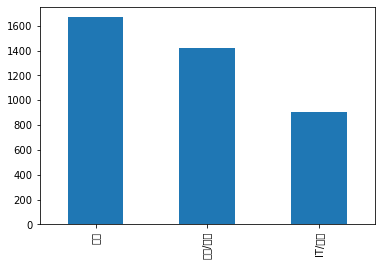

In [48]:
##  사회, 생활/문화, IT/과학. 한글 깨짐
print(df.groupby('code').size().reset_index(name='count'))
df['code'].value_counts().plot(kind='bar')

## 토큰화

In [89]:
from konlpy.tag import Mecab
tokenizer = Mecab()
kor_text = '한 편의 너, 한 컷의 너, 질리지도 않나봐 오늘도 집에 와 너를 틀고서 네 입모양 따라 대사를 외워봐 아주 잘 찍은 너, 한 편, 너 한 편. 참 영화같은 사랑이었음을. 참 영화같은 사람이었음을. 눈 앞에 있어도, 널 찍으면서도 난 알지 못했어. 너무 바보처럼. 한 편의 너, 한 컷의 너, 질리지도 않나봐 오늘도 집에 와 너를 틀고서'
print(tokenizer.morphs(kor_text)) # 형태소 단위 토큰화

['한', '편', '의', '너', ',', '한', '컷', '의', '너', ',', '질리', '지', '도', '않', '나', '봐', '오늘', '도', '집', '에', '와', '너', '를', '틀', '고서', '네', '입', '모양', '따라', '대사', '를', '외워', '봐', '아주', '잘', '찍', '은', '너', ',', '한', '편', ',', '너', '한', '편', '.', '참', '영화', '같', '은', '사랑', '이', '었', '음', '을', '.', '참', '영화', '같', '은', '사람', '이', '었', '음', '을', '.', '눈', '앞', '에', '있', '어도', ',', '널', '찍', '으면서', '도', '난', '알', '지', '못했', '어', '.', '너무', '바보', '처럼', '.', '한', '편', '의', '너', ',', '한', '컷', '의', '너', ',', '질리', '지', '도', '않', '나', '봐', '오늘', '도', '집', '에', '와', '너', '를', '틀', '고서']


## 불용어 제거

In [79]:
stopwords = ['의','도','를','봐','었','음','에','는','은','을','했','에게','있','이','의','하','한','다','과','때문','할','수','무단','따른','및','금지','전재','경향신문','기자','는데','가','등','들','파이낸셜','저작','등','뉴스']
# 불용어는 미리 짐작하여 한 번에 정의하는 것이 아니라, 토큰화 과정을 거친 결과를 지속적으로 확인하면서 계속해서 추가하게 되는 것이 일반적입니다. 
# 토큰화 함수를 몇 차례 실행 및 확인하면서 추가해봅니다.

In [104]:
# 토큰화 및 불용어 제거
def preprocessing(data):
    text_data = []
    
    for sentence in data:
        temp_data = []
        temp_data = tokenizer.morphs(sentence)
        temp_data = [word for word in temp_data if not word in stopwords]
        text_data.append(temp_data)
        
    text_data = list(map(' '.join, text_data))
    
    return text_data

In [105]:
text_data = preprocessing(df['news'])
print(text_data[0])

파주 시청 사진제 공파 주시 파주 시청 사진 제공 파주시 파주 강근주 파 주 시 일 관내 취약 계층 만 가구 대해 정부 긴급 재난 지원금 입금 완료 다파 주 시민 받 긴급 재난 지원금 인 이상 가구 기준 으로 만 원 받 게 되 며 인 가구 만 원 인 가구 만 원 인 가구 만 원 정부 발표 긴급 재난 지원금 파주 시민 지급 금액 다른 이유 국비 지방비 부담 비율 다파 주 시 이미 모든 시민 경기도 파주시 재난 기본 소득 인 당 각 만 원 지급 고 어 시민 국비 지원금 만 지급 며 인 가구 기준 으로 총 지원 금액 파주시 재난 기본소득 만 원 경기도 재난 기본소득 만 원 정부 긴급 재난 지원금 만 원 총 만 원 받 게 된다 취약 계층 아닌 시민 오 월일 부터 소지 고 신용 체크카드 사 홈페이지 에서 긴급 재난 지원금 지원 신청 세대주 가족 지원금 일괄 신청 해야 한다 한편 파 주 시 일 김정기 부시장 단장 으로 긴급 재난 지원금 추진 태 스 크 포스 구성 해 긴급 재난 지원금 원활 게 지급 될 도록 지원 한다 권 자 재 배포


## 나이브 베이즈 분류기
![naive](https://i2.wp.com/hleecaster.com/wp-content/uploads/2020/01/nbc01.png?w=438)

1. 텍스트 데이터를 벡터로 바꾸어 주기 위해, 각 문장 안의 단어 빈도 구하기(frequency)
2. 단어가 많이 나오는 것이 중요한 게 아니라, 다른 문장과 비교해서 많이 나온 것이 중요함. 단어가 다른 문장에 나온 빈도 대비 해당 문장에 나온 빈도를 구하기 위해 TF-IDF 로 변환
3. 어떤 단어가 있을 때, 어떤 카테고리인지 구하기 = P(카테고리|단어)

In [108]:
# 사이킷런
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

In [107]:
# 훈련 테스트와 데이터 테스트 분리
X_train, X_test, y_train, y_test = train_test_split(text_data, df['code'], random_state = 0)
print('훈련용 뉴스 기사의 개수 :', len(X_train))
print('테스트용 뉴스 기사의 개수 : ', len(X_test))
print('훈련용 레이블의 개수 : ', len(y_train))
print('테스트용 레이블의 개수 : ', len(y_test))

훈련용 뉴스 기사의 개수 : 2995
테스트용 뉴스 기사의 개수 :  999
훈련용 레이블의 개수 :  2995
테스트용 레이블의 개수 :  999


In [125]:
# 1. 단어 빈도 구하기 = (사이킷런) CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train) 
# fit_transform() 함수는 fit과 transform을 연이어 수행하는 함수로, 단어 데이터를 학습하고 문서 데이터를 document-form matrix로 변환하는 두 가지 작업을 해 줍니다.
# 여기서의 fit은 단어 종류를 학습 하는 것. apple = 1, banana = 2 이런 식으로 단어를 representing 하는 숫자가 부여되는데, 이 숫자를 부여하는 학습 과정이라고 볼 수 있다.

# 2. TF-IDF 변환
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

# 3. 나이브 베이즈 분류기 수행
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [127]:
print(X_train_counts.shape)
print(X_train_counts[1])

(2995, 32099)
  (0, 19)	1
  (0, 49)	4
  (0, 217)	1
  (0, 774)	1
  (0, 944)	1
  (0, 1074)	2
  (0, 1312)	7
  (0, 1424)	2
  (0, 2064)	3
  (0, 2206)	2
  (0, 2577)	1
  (0, 2772)	1
  (0, 2977)	1
  (0, 3602)	1
  (0, 3731)	1
  (0, 3732)	3
  (0, 3761)	2
  (0, 4438)	2
  (0, 4777)	1
  (0, 4833)	1
  (0, 5407)	1
  (0, 5820)	1
  (0, 5992)	2
  (0, 6009)	1
  (0, 6047)	1
  :	:
  (0, 24478)	1
  (0, 24567)	1
  (0, 24629)	1
  (0, 25106)	1
  (0, 25288)	1
  (0, 25382)	1
  (0, 25534)	1
  (0, 25604)	1
  (0, 25671)	2
  (0, 25690)	1
  (0, 25692)	4
  (0, 25710)	1
  (0, 27000)	2
  (0, 27181)	1
  (0, 27613)	1
  (0, 27771)	1
  (0, 28000)	2
  (0, 29075)	2
  (0, 29986)	1
  (0, 30249)	2
  (0, 31029)	1
  (0, 31126)	1
  (0, 31253)	2
  (0, 31288)	4
  (0, 31661)	1


In [128]:
def tfidf_vectorizer(data):
    data_counts = count_vect.transform(data)
    # 여기서 fit을 안 쓰는 것은, test 데이터에서만 새롭게 나온 단어는 학습된 모델에서 등장하지 않았기 때문에 평가할 때 반영을 안하게 된다는 것
    data_tfidf = tfidf_transformer.transform(data_counts)
    return data_tfidf

In [129]:
new_sent = preprocessing(["민주당 일각에서 법사위의 체계·자구 심사 기능을 없애야 한다는 \
                           주장이 나오는 데 대해 “체계·자구 심사가 법안 지연의 수단으로 \
                          쓰이는 것은 바람직하지 않다”면서도 “국회를 통과하는 법안 중 위헌\
                          법률이 1년에 10건 넘게 나온다. 그런데 체계·자구 심사까지 없애면 매우 위험하다”고 반박했다."])
print(clf.predict(tfidf_vectorizer(new_sent))) # clf.predict() 는 입력한 tfidf 데이터에 대해 나이브 베이즈 분류기 모델이 예측한 값을 리턴

['사회']


In [130]:
y_pred = clf.predict(tfidf_vectorizer(X_test))
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

       IT/과학       0.90      0.74      0.81       236
          사회       0.79      0.91      0.85       422
       생활/문화       0.81      0.76      0.79       341

    accuracy                           0.82       999
   macro avg       0.83      0.80      0.81       999
weighted avg       0.82      0.82      0.82       999



## 새로운 데이터 추가

In [145]:
import os
csv_path = os.getenv("HOME") + "/aiffel/news_crawler/news_data.csv"
df = pd.read_table(csv_path, sep=',')
print("code{}를 가진 기사 데이터들".format(code_list))
df.head()

code[102, 103, 105]를 가진 기사 데이터들


,news,code
0,파주시청. 사진제공=파주시 파주시청. 사진제공=파주시\n\n[파주=파이낸셜뉴스 강근...,사회
1,동영상 뉴스\n\n이천 물류창고 화재 발화지점으로 지목된 지하 2층에서 산소절단기의...,사회
2,황범순 의정부시 부시장 을지대학교 의정부캠퍼스 및 부속병원 공사현장 안전점검. 사진...,사회
3,귀갓길 여성을 쫓아가 성범죄를 시도한 20대 남성이 구속됐습니다.서울 강남경찰서는 ...,사회
4,(서울=연합뉴스) 대한약사회가 6일부터 코로나바이러스 감염증 대응 체계를 '사회적 ...,사회


In [160]:
url_list_add = make_urllist(50,101,20200506)
print(len(url_list_add))

1000


In [161]:
data_add = make_data(url_list_add, 101)

In [162]:
df = pd.concat([df, data_add])

In [164]:
print(df.isnull().sum()) # 데이터에 null 값이 있는지 확인하기
df.drop_duplicates(subset=['news'], inplace=True) #데이터에 중복이 있으면 중복 제거
df['news'] = df['news'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식을 이용해서 한글 외의 문자 전부 제거
df.tail()
print('뉴스 기사의 개수:', len(df))
print(df.groupby('code').size().reset_index(name='count'))

news    0
code    0
dtype: int64
뉴스 기사의 개수: 4820
    code  count
0  IT/과학    903
1     경제    826
2     사회   1668
3  생활/문화   1423


## 다른 형태소 분석기 사용하기

In [170]:
from konlpy.tag import Kkma
tokenizer = Kkma()
stopwords = ['파주','경기도','인천','부산','서울','의','도','를','봐','었','음','에','는','은','을','했','에게','있','이','의','하','한','다','과','때문','할','수','무단','따른','및','금지','전재','경향신문','기자','는데','가','등','들','파이낸셜','저작','등','뉴스']

In [171]:
text_data = preprocessing(df['news'])

In [172]:
X_train, X_test, y_train, y_test = train_test_split(text_data, df['code'], random_state = 0)
print('훈련용 뉴스 기사의 개수 :', len(X_train))
print('테스트용 뉴스 기사의 개수 : ', len(X_test))
print('훈련용 레이블의 개수 : ', len(y_train))
print('테스트용 레이블의 개수 : ', len(y_test))

훈련용 뉴스 기사의 개수 : 3615
테스트용 뉴스 기사의 개수 :  1205
훈련용 레이블의 개수 :  3615
테스트용 레이블의 개수 :  1205


In [173]:
X_train_counts = count_vect.fit_transform(X_train) 
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [176]:
y_pred = clf.predict(tfidf_vectorizer(X_test))
print(metrics.classification_report(y_test,y_pred))
# 성능을 좋게 하기 위해서는, 다른 형태소 분석기 또는 다양한 preprocessing 방법을 시도해 볼 수 있다.

              precision    recall  f1-score   support

       IT/과학       0.87      0.72      0.79       228
          경제       0.90      0.50      0.65       210
          사회       0.69      0.91      0.78       421
       생활/문화       0.78      0.76      0.77       346

    accuracy                           0.76      1205
   macro avg       0.81      0.72      0.75      1205
weighted avg       0.78      0.76      0.76      1205

